Notebook to replicate our results for data set 1 which does not use a RNN for condition procession

In [1]:
import copy
import torch.nn as nn
import torch
from FrEIA.framework import *
from FrEIA.modules import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
device = torch.device("cuda:0")

In [2]:
def load_data():
    """
    Helper function to read the data which is saved in multiple .csv files
    converts data to pytorch tensors
    """
    all_data = []
    all_params = []
    all_length = []
    i = 0
    j = 0
    while(True):
        name_dat = f"./data_immune{j}/dat{i}.csv"
        name_param = f"./params_immune{j}/params{i}.csv"
        try:
            df_dat = pd.read_csv(name_dat)
            df_param = pd.read_csv(name_param)
            param = df_param.to_numpy()[0,[1]]
            data = df_dat.iloc[:,2].to_numpy().reshape(-1,7)[:,1]
            if len(data[np.isnan(data)]) == 0:
                all_data.append(data)
                all_params.append(param)
                all_length.append(len(data))
            else:
                print(i)
            i += 1
        except Exception as e:
            i = 0
            j += 1
        if j>8:
            print(f"loaded {len(all_data)} entries")
            break
        if len(all_data)%1000 == 0:
            print("Loaded",len(all_data),"Entries")

    all_params = torch.from_numpy(np.array(all_params)).to(torch.float32).to(device)
    all_data = torch.from_numpy(np.array(all_data)).to(torch.float32).to(device)
    return all_data, all_params, all_length


data, params, length = load_data()
data_dict = {"data": data,
            "params": params,
            "length": length}

torch.save(data_dict, "data_first.save")

'\ndata, params, length = load_data()\ndata_dict = {"data": data,\n            "params": params,\n            "length": length}\n\ntorch.save(data_dict, "data_first.save")\n'

In [3]:
#data_dict = torch.load("data_first.save", map_location = device)

In [4]:
data = data_dict["data"][:270000]
params = data_dict["params"][:270000]
length = data_dict["length"][:270000]
test_dat = data_dict["data"][270000:]
test_params = data_dict["params"][270000:]
test_length = data_dict["length"][270000:]

In [5]:
class preprocessor():
    """
    Used to save initial means and range of the parameters and
    applies the preprocessing
    
    """
    def __init__(self, params):
        self.means = params.mean(dim = 0)
        self.max = torch.abs(params-self.means).max(dim = 0)[0]+1e-5
 
    def __call__(self, params, fwd = True):
        #return params
        if fwd:
            return torch.arctanh((params - self.means)/self.max)
        else:
            return torch.tanh(params) * self.max + self.means

prepper = preprocessor(params)
prepped = prepper(params, fwd = True)

In [6]:
def get_linear_subnet(N, inp_size, hidden_size, out_size):
    """
    Helper function to get linear network with ReLU activation
    N: amount of layers, not including the final linear output layer
    inp_size: dimension of the input
    hidden_size: width of the N-1 hidden layers
    out_size: dimension of the output
    """
    if N == 0:
        return None
    layer_list = []
    layer_list.append(nn.Linear(inp_size, hidden_size))
    layer_list.append(nn.ReLU())
    for i in range(N-1):
        layer_list.append(nn.Linear(hidden_size, hidden_size))
        layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(hidden_size, out_size))
    return nn.Sequential(*layer_list).to(device)


class cINN(nn.Module):
    """
    cINN baseclass, using cubic spline blocks.
    inp_size: dimension of the input
    cond_size: dimension of the conditions
    num_blocks: amount of coupling blocks used
    sub_layers: amount of linear layers in the subnetworks
    sub_width: width of the subnetworks
    lr: learning rate, scheduler used is reduce_on_plateau
    """
    def __init__(self, inp_size, cond_size, num_blocks = 5, sub_layers = 3, sub_width = 256, lr = 2e-4):
        super(cINN, self).__init__()
        constructor_fct = lambda x_in, x_out: get_linear_subnet(sub_layers, 
                                                                x_in,
                                                                sub_width,
                                                                x_out)

        block_kwargs = {
                        "num_bins": 60,
                        "subnet_constructor": constructor_fct,
                        "bounds_init": 5,
                        "permute_soft": False
                           }
        inp_size = (inp_size,)        
        nodes = [InputNode(*inp_size, name='inp')]
        cond_node = ConditionNode(*(cond_size,))
        for i in range(num_blocks):
            nodes.append(Node(
                    [nodes[-1].out0],
                    CubicSplineBlock,
                    block_kwargs,
                    conditions = cond_node,
                    name = f"block_{i}",
                    
                ))
        nodes.append(OutputNode([nodes[-1].out0], name='out'))
        nodes.append(cond_node)
        self.model = GraphINN(nodes, verbose=False).to(device)
        self.params_trainable = list(filter(
                lambda p: p.requires_grad, self.model.parameters()))
        n_trainable = sum(p.numel() for p in self.params_trainable)
        print(f"Number of cINN parameters: {n_trainable}", flush=True)
        
        self.optimizer = torch.optim.AdamW(
                self.params_trainable,
                lr = lr,
                betas =[0.9, 0.99],
                eps = 1e-6,
                weight_decay = 0
            )
        self.scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                verbose = True
            )
    def forward(self, x, cond = None, rev = False):
        return self.model(x, c = cond, rev = rev)


    
class Estimator():
    """
    Wrapper for training the cINN and inference
    """
    def __init__(self, cinn):
        self.cinn = cinn
        
    def metrik(self, true, data, gauss):
        """
        Used to measure the distance between truth and generated parameters
        Better interpretable than the Loss function
        """
        with torch.no_grad():
            output, _ = self.cinn(gauss, data, rev = True)
            output = torch.abs(prepper(output, fwd = False) - prepper(true, fwd = False))
            output = torch.mean(output, dim = 0).cpu().numpy()
        print("Metric:",output)
        return output
    
    def train(self, epochs, xtrain, ytrain, batch_size):
        """
        Trains the cINN and shows loss and metric plots
        epochs: amount of epochs to train
        xtrain: training parameters
        ytrain: corresponding time series
        batch_size: Batch size used for the training
        """
        loss_curve = []
        metrics_curve = []
        zeros = torch.zeros(batch_size,1).to(device)
        for epoch in range(epochs):
            epoch_index = np.random.permutation(len(xtrain))
            epoch_losses = 0
            for i in range(len(xtrain)//batch_size):
                cond = ytrain[epoch_index][i*batch_size:(i+1)*batch_size]
                xsamps = xtrain[epoch_index][i*batch_size:(i+1)*batch_size]
                self.cinn.optimizer.zero_grad()
                
                loss = 0

                gauss, jac = self.cinn(xsamps, cond)
                loss = torch.mean(gauss**2/2) - torch.mean(jac)/gauss.shape[1]
                    
                loss.backward()
                self.cinn.optimizer.step()

                epoch_losses += loss.item()/(len(xtrain)//batch_size)
            loss_curve.append(epoch_losses)
            
            self.cinn.scheduler.step(epoch_losses)
            print("Epoch:", epoch + 1)
            print("Loss:", epoch_losses)
            metrics_curve.append(self.metrik(xsamps,cond, zeros))
        plt.plot(np.arange(len(loss_curve)),np.array(loss_curve), label = "Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()
        metrics_curve = np.array(metrics_curve)
        for i in range(metrics_curve.shape[1]):
            plt.plot(np.arange(len(loss_curve)), metrics_curve[:,i], label = f"Metric $x_{i}$")
        plt.xlabel("Epoch")
        plt.ylabel("Metric")

        
    def inference(self, data_point, true_param = None):
        """
        Predicts a parameter distribution for given time series
        Overlays the true parameter to see how well the network performs
        """
        outputs = []
        with torch.no_grad():
            for i in range(100):
                gauss = torch.randn(1000,1).to(device)
                cond = data_point.repeat(1000,1,1).to(device).view(-1,100)
                output, _ = self.cinn(gauss, cond, rev = True)
                outputs.append(output)
        output = torch.cat(outputs, dim = 0)
        output = prepper(output, fwd = False).detach().cpu()

        plt.hist(output.numpy()[:,0], bins = 100, density = True, label = "Generated")
        if true_param != None:
            plt.axvline(true_param[0], color = "r", label = "Truth")
        plt.xlabel("Initial Immune", fontsize = 12)
        plt.legend()
        plt.ylabel("Normalized", fontsize = 12)

Number of cINN parameters: 943970
Metrik: [0.03001976]
Epoch: 1
Loss: -0.5336053907188751
Metrik: [0.03278863]
Epoch: 2
Loss: -0.8364717500810404
Metrik: [0.03174226]
Epoch: 3
Loss: -0.850597468951276
Metrik: [0.03155794]
Epoch: 4
Loss: -0.8555430419572435
Metrik: [0.03066232]
Epoch: 5
Loss: -0.8590355570079715
Metrik: [0.03161217]
Epoch: 6
Loss: -0.8572344306771081
Metrik: [0.03282179]
Epoch: 7
Loss: -0.8620966768446765
Metrik: [0.03203502]
Epoch: 8
Loss: -0.8626830295752025
Metrik: [0.03004811]
Epoch: 9
Loss: -0.8638824661269444
Metrik: [0.03251021]
Epoch: 10
Loss: -0.8626266927209518


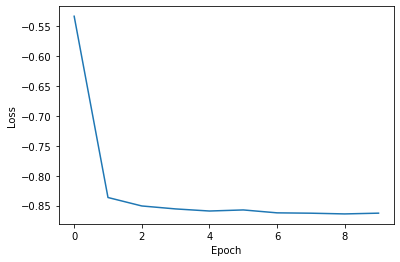

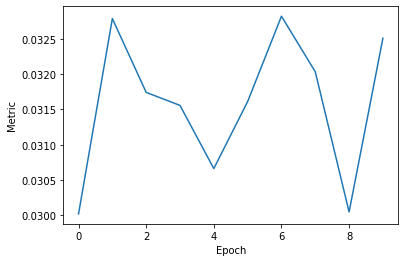

In [7]:
cinn = cINN(1,100)
net = Estimator(cinn)
net.train(10, prepped, data, batch_size = 2048)

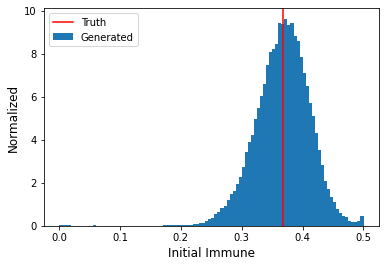

In [12]:
i = np.random.randint(len(test_dat))
network = Estimator(cinn)
network.inference(test_dat[i], test_params[i])

In [9]:
"""
Importing the covid data from Germany to test the network on it

"""

cov_data = pd.read_csv("owid-covid-data.csv")
germany = cov_data[cov_data["location"] == "Germany"]
total_cases = germany["total_cases"].to_numpy()[3:]/80000000
active_cases = total_cases.copy()
for i in range(len(total_cases)-20):
    active_cases[i+20]-= total_cases[i]
immune = germany["people_fully_vaccinated"].to_numpy()[3:]/80000000
immune[immune != immune] = 0
active_cases = torch.from_numpy(active_cases).to(device).to(torch.float)

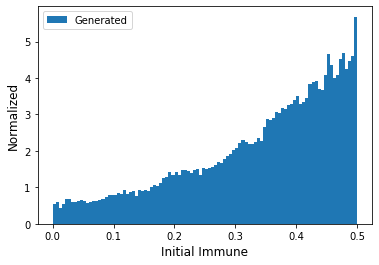

In [10]:
network.inference(active_cases[500:600])

In [11]:
def plotter(data):
    """
    plot the timeseries
    """
    try:
        data = data.cpu().numpy()
    except:
        pass
    susceptible = data[:,0]
    infected = data[:,1]
    immune = data[:,2]
    time = np.arange(len(immune))
    plt.plot(time,susceptible, label = "Susceptible")
    plt.plot(time,infected, label = "Infected")
    plt.plot(time,immune, label = "Immune/Recovered")
    plt.legend()